# Time Series Analysis on AirBnB dataset

### Context

The data set is freely available here: http://insideairbnb.com/get-the-data.html

We are using the 'Los Angeles' section for our project.  

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML, display_html
import seaborn as sns
import datetime

# set formatting
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [3]:
# read in CSV file data
df = pd.read_csv('./datasets/AirBnB_reviews.csv')
df.head()

,listing_id,date
0,109,2011-08-15
1,109,2016-05-15
2,344,2016-06-14
3,344,2016-12-11
4,344,2016-12-30


In [4]:
df.shape

(1171855, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171855 entries, 0 to 1171854
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1171855 non-null  int64 
 1   date        1171855 non-null  object
dtypes: int64(1), object(1)
memory usage: 17.9+ MB


In [6]:
df.isnull().any()

listing_id    False
date          False
dtype: bool

In [7]:
df.describe()

,listing_id
count,1.171855e+06
mean,1.616070e+07
std,1.120858e+07
min,1.090000e+02
25%,6.292624e+06
50%,1.546428e+07
75%,2.363464e+07
max,4.500164e+07


### Understanding the dataset

Let's understand the limitations of the data and what potential questions can be answered by the data.

**Data** We have daily count of reviews for given listing ids for given dates.

**Questions we can look into**

* Forecast future number of reviews for the Los Angeles area.
* Forecast the future number of reviews for specific listings in the Los Angeles area.

## Time-Series Analysis Models

### Statistical models
* Averaging and smoothing models, ARIMA models.
* Regression-based models.
* Facebook Prophet package.
* Bayesian structural time series modeling

### Machine learning models
* Support Vector Machines (SVMs), Random Forest Regression, Gradient-Boosted Decision Trees (GBDTs).
* Hidden markov models (HMMs).
* Other sequence-based models.
* Recurrent neural networks (RNNs).

### Processing the data

In [8]:
# Rename columns
df = df.rename(columns = {'date': 'ds', 'listing_id': 'ts'})

# Group data by number of listings per date
df_example = df.groupby(by = 'ds').agg({'ts': 'count'})

# Change index to datetime
df_example.index = pd.to_datetime(df_example.index)

# Set frequency of time series
df_example = df_example.asfreq(freq='1D')

# Sort the values
df_example = df_example.sort_index(ascending = True)

# Fill values with 0
df_example = df_example.fillna(value = 0)

# Show the end of the data
df_example.tail()

,ts
ds,
2020-08-17,518.0
2020-08-18,247.0
2020-08-19,228.0
2020-08-20,132.0
2020-08-21,49.0


### Visualizing the data
- There does appear to be an overall increasing trend. 
- There appears to be some differences in the variance over time. 
- There may be some seasonality (i.e., cycles) in the data.
- Not sure about outliers.

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

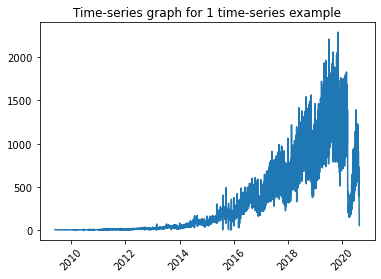

In [10]:
# Plot time series data
f, ax = plt.subplots(1,1)
ax.plot(df_example['ts'])

# Add title
ax.set_title('Time-series graph for 1 time-series example')

# Rotate x-labels
ax.tick_params(axis = 'x', rotation = 45)

# Show graph
plt.show()

### Checking for stationarity

Most time-series models assume that the underlying time-series data is **stationary**.  This assumption gives us some nice statistical properties that allows us to use various models for forecasting.

**Stationarity** is a statistical assumption that a time-series has:
*   **Constant mean**
*   **Constant variance**
*   **Autocovariance does not depend on time**

**Looking at the data:**
- Rolling mean and standard deviation look like they change over time.  There may be some de-trending and removing seasonality involved. Based on **Dickey-Fuller test**, because p = 0.31, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that we fail to reject the null hypothesis that our **time series is not stationary**.

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

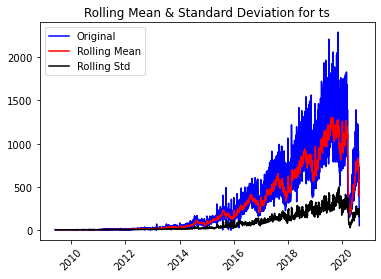

Results of Dickey-Fuller Test:
Test Statistic                   -2.029608
p-value                           0.273744
# Lags Used                      31.000000
Number of Observations Used    4074.000000
Critical Value (1%)              -3.431956
Critical Value (5%)              -2.862250
Critical Value (10%)             -2.567148
dtype: float64


In [12]:
test_stationarity(df = df_example, ts = 'ts')

### Correcting for stationarity

It is common for time series data to have to correct for non-stationarity. 

2 common reasons behind non-stationarity are:

1. **Trend** – mean is not constant over time.
2. **Seasonality** – variance is not constant over time.

There are ways to correct for trend and seasonality, to make the time series stationary.

### Eliminating trend and seasonality
*   Transformation
  *   Log, square root, etc.
*   Smoothing
  *   Weekly average, monthly average, rolling averages.
*   Differencing
  *  First-order differencing.
*   Polynomial Fitting
  *  Fit a regression model.
*   Decomposition

### Transformation, Smoothing, and Differencing

- We are applying log transformation, weekly moving average smoothing, and differencing the data to make the data more stationary over time.

In [13]:
def plot_transformed_data(df, ts, ts_transform):
    """
      Plot transformed and original time series data
      """
    # Plot time series data
    f, ax = plt.subplots(1,1)
    ax.plot(df[ts])
    ax.plot(df[ts_transform], color = 'red')

  # Add title
    ax.set_title('%s and %s time-series graph' %(ts, ts_transform))

  # Rotate x-labels
    ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
    ax.legend([ts, ts_transform])
  
    plt.show()
  
    return

C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas\core\algorithms.py:1926: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
<ipython-input-14-4da2376f756a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
<ipython-input-14-4da2376f756a>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts

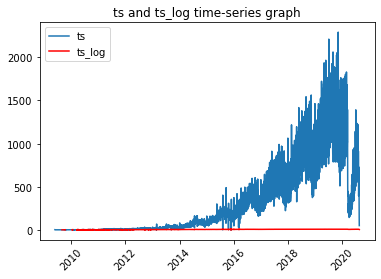

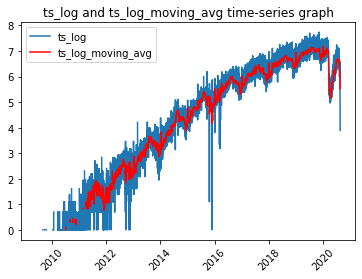

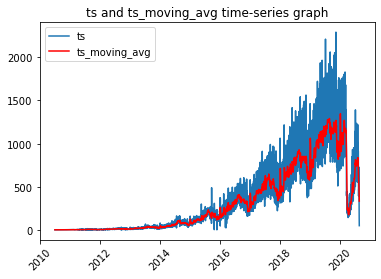

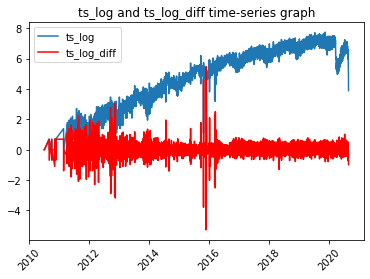

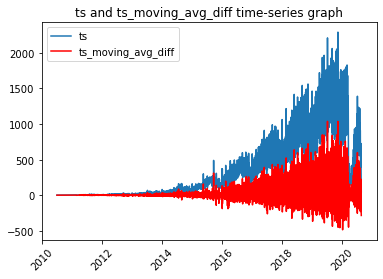

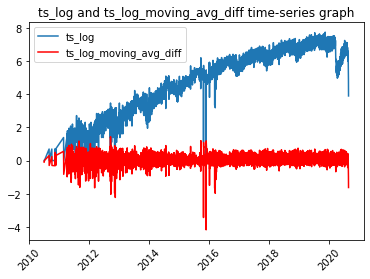

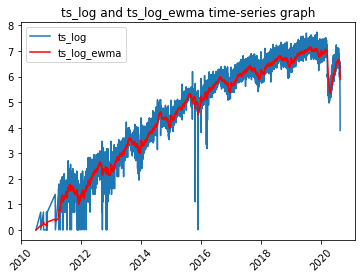

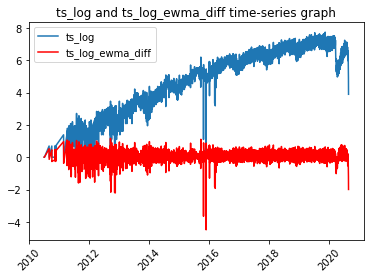

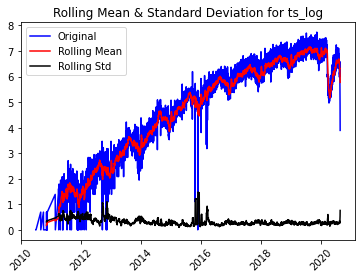

Results of Dickey-Fuller Test:
Test Statistic                   -2.366622
p-value                           0.151380
# Lags Used                      29.000000
Number of Observations Used    3303.000000
Critical Value (1%)              -3.432331
Critical Value (5%)              -2.862415
Critical Value (10%)             -2.567236
dtype: float64


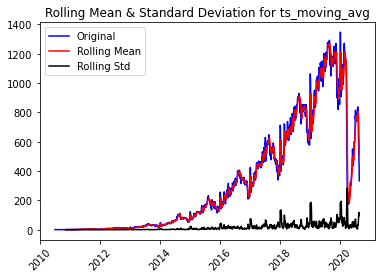

Results of Dickey-Fuller Test:
Test Statistic                   -1.872744
p-value                           0.344990
# Lags Used                      29.000000
Number of Observations Used    3303.000000
Critical Value (1%)              -3.432331
Critical Value (5%)              -2.862415
Critical Value (10%)             -2.567236
dtype: float64


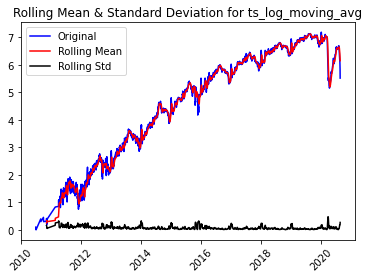

Results of Dickey-Fuller Test:
Test Statistic                   -2.328844
p-value                           0.162834
# Lags Used                      28.000000
Number of Observations Used    3304.000000
Critical Value (1%)              -3.432331
Critical Value (5%)              -2.862415
Critical Value (10%)             -2.567236
dtype: float64


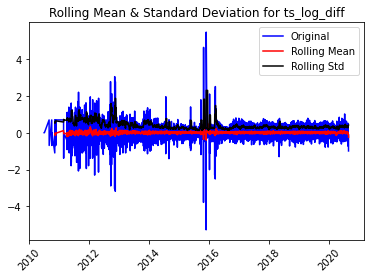

Results of Dickey-Fuller Test:
Test Statistic                -1.107013e+01
p-value                        4.575476e-20
# Lags Used                    2.900000e+01
Number of Observations Used    3.303000e+03
Critical Value (1%)           -3.432331e+00
Critical Value (5%)           -2.862415e+00
Critical Value (10%)          -2.567236e+00
dtype: float64


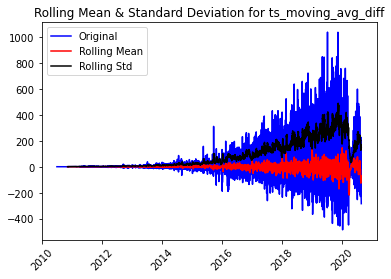

Results of Dickey-Fuller Test:
Test Statistic                -9.487907e+00
p-value                        3.719746e-16
# Lags Used                    2.800000e+01
Number of Observations Used    3.304000e+03
Critical Value (1%)           -3.432331e+00
Critical Value (5%)           -2.862415e+00
Critical Value (10%)          -2.567236e+00
dtype: float64


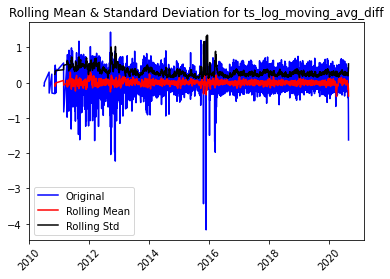

Results of Dickey-Fuller Test:
Test Statistic                -1.113847e+01
p-value                        3.151573e-20
# Lags Used                    2.900000e+01
Number of Observations Used    3.303000e+03
Critical Value (1%)           -3.432331e+00
Critical Value (5%)           -2.862415e+00
Critical Value (10%)          -2.567236e+00
dtype: float64


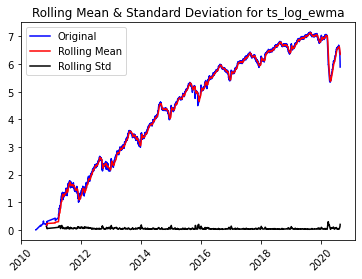

Results of Dickey-Fuller Test:
Test Statistic                   -2.420666
p-value                           0.135988
# Lags Used                      29.000000
Number of Observations Used    3303.000000
Critical Value (1%)              -3.432331
Critical Value (5%)              -2.862415
Critical Value (10%)             -2.567236
dtype: float64


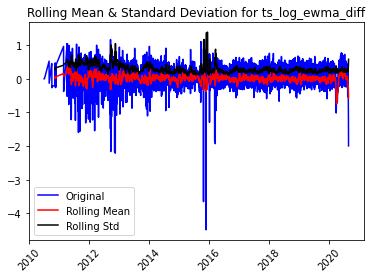

Results of Dickey-Fuller Test:
Test Statistic                -9.279080e+00
p-value                        1.265432e-15
# Lags Used                    2.900000e+01
Number of Observations Used    3.303000e+03
Critical Value (1%)           -3.432331e+00
Critical Value (5%)           -2.862415e+00
Critical Value (10%)          -2.567236e+00
dtype: float64


In [14]:
# Transformation - log ts
df_example['ts_log'] = df_example['ts'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log ts
df_example['ts_log_moving_avg'] = df_example['ts_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average ts
df_example['ts_moving_avg'] = df_example['ts'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged ts and first-order difference logged ts
# df_example['ts_log_diff'] = df_example['ts_log'] - df_example['ts_log'].shift()
df_example['ts_log_diff'] = df_example['ts_log'].diff()

# Transformation - Difference between ts and moving average ts
df_example['ts_moving_avg_diff'] = df_example['ts'] - df_example['ts_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example['ts_log_moving_avg_diff'] = df_example['ts_log'] - df_example['ts_log_moving_avg']

# Transformation - Difference between logged ts and logged moving average ts
df_example_transform = df_example.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) ts
df_example_transform['ts_log_ewma'] = df_example_transform['ts_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged ts and logged EWMA ts
df_example_transform['ts_log_ewma_diff'] = df_example_transform['ts_log'] - df_example_transform['ts_log_ewma']



# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts', 
                      ts_transform = 'ts_log')
# Plot data
plot_transformed_data(df = df_example, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts', 
                      ts_transform = 'ts_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma')

# Plot data
plot_transformed_data(df = df_example_transform, 
                      ts = 'ts_log', 
                      ts_transform = 'ts_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_example_transform, 
                  ts = 'ts_log_ewma')

# Perform stationarity test
test_stationarity(df = df_example_transform,
                  ts = 'ts_log_ewma_diff')

Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

In [15]:
# Display data
df_example_transform.head()

,ts,ts_log,ts_log_moving_avg,ts_moving_avg,ts_log_diff,ts_moving_avg_diff,ts_log_moving_avg_diff,ts_log_ewma,ts_log_ewma_diff
ds,,,,,,,,,
2010-07-03,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-04,1.0,0.000000,0.099021,1.142857,0.000000,-0.142857,-0.099021,0.000000,0.000000
2010-07-05,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-07-06,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-09-01,2.0,0.693147,0.396084,1.571429,0.693147,0.428571,0.297063,0.167346,0.525801


### Decomposition: trend, seasonality, residuals

We will be de-trending and de-seasonalizing the data to make it more stationary over time.

In [16]:
def plot_decomposition(df, ts, trend, seasonal, residual):
    """
    Plot time series data
    """
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

    ax1.plot(df[ts], label = 'Original')
    ax1.legend(loc = 'best')
    ax1.tick_params(axis = 'x', rotation = 45)

    ax2.plot(df[trend], label = 'Trend')
    ax2.legend(loc = 'best')
    ax2.tick_params(axis = 'x', rotation = 45)

    ax3.plot(df[seasonal],label = 'Seasonality')
    ax3.legend(loc = 'best')
    ax3.tick_params(axis = 'x', rotation = 45)

    ax4.plot(df[residual], label = 'Residuals')
    ax4.legend(loc = 'best')
    ax4.tick_params(axis = 'x', rotation = 45)
    plt.tight_layout()

    # Show graph
    plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(ts), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
    plt.show()

    return

<ipython-input-17-aa4494657de5>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)
C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Chaitanya\anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]

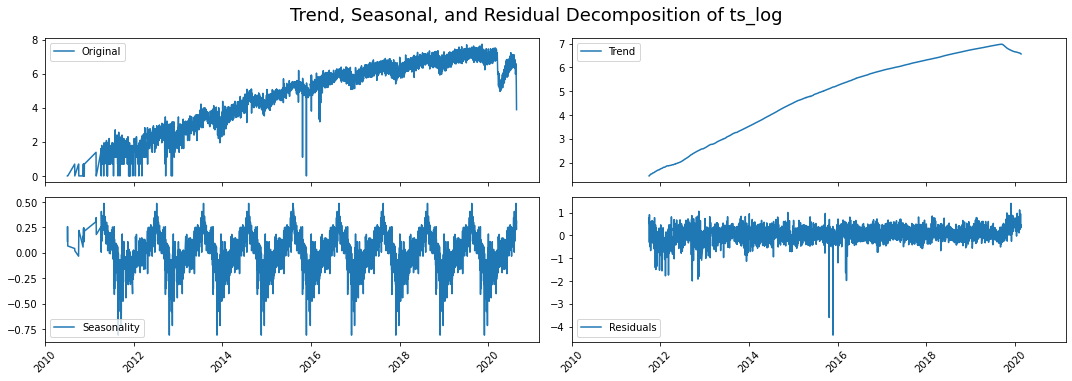

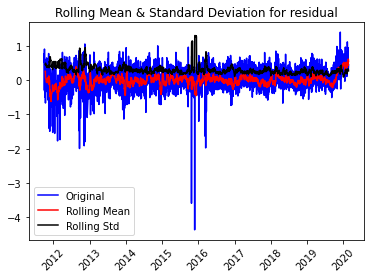

Results of Dickey-Fuller Test:
Test Statistic                   -5.327261
p-value                           0.000005
# Lags Used                      29.000000
Number of Observations Used    2939.000000
Critical Value (1%)              -3.432577
Critical Value (5%)              -2.862524
Critical Value (10%)             -2.567294
dtype: float64


In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_example_transform['ts_log'], freq = 365)

df_example_transform.loc[:,'trend'] = decomposition.trend
df_example_transform.loc[:,'seasonal'] = decomposition.seasonal
df_example_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_example_transform, 
                   ts = 'ts_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_example_transform.dropna(), ts = 'residual')

Based on **Dickey-Fuller test**, because p = < 0.05, we fail to reject the null hypothesis (that the time series is not stationary) at the p = 0.05 level, thus concluding that the **time series is stationary**.

### ARIMA models.


ARIMA = Auto-Regressive Integrated Moving Average.  
Assumptions: The time-series is stationary.  
Depends on:
  1. Number of AR (Auto-Regressive) terms (p).
  2. Number of I (Integrated or Difference) terms (d). 
  3. Number of MA (Moving Average) terms (q).

#### ACF and PACF Plots
To determine p and q values we use ACF and PACF plots.

Autocorrelation Function (ACF): Correlation between the time series with a lagged version of itself (e.g., correlation of Y(t) with Y(t-1)).

Partial Autocorrelation Function (PACF): Additional correlation explained by each successive lagged term.

How do we interpret ACF and PACF plots?
- p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
- q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

In [18]:
def plot_acf_pacf(df, ts):
    """
    Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
    """
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

    #Plot ACF: 

    ax1.plot(lag_acf)
    ax1.axhline(y=0,linestyle='--',color='gray')
    ax1.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax1.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax1.set_title('Autocorrelation Function for %s' %(ts))

    #Plot PACF:
    ax2.plot(lag_pacf)
    ax2.axhline(y=0,linestyle='--',color='gray')
    ax2.axhline(y=-1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax2.axhline(y=1.96/np.sqrt(len(df[ts])),linestyle='--',color='gray')
    ax2.set_title('Partial Autocorrelation Function for %s' %(ts))

    plt.tight_layout()
    plt.show()
    plt.close()

    return

C:\Users\Chaitanya\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


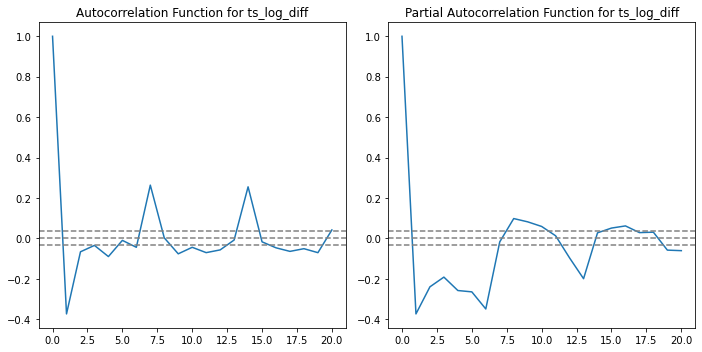

In [19]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(df_example_transform['ts_log_diff']), nlags = 20)
lag_pacf = pacf(np.array(df_example_transform['ts_log_diff']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_example_transform, ts = 'ts_log_diff')

In [20]:
def run_arima_model(df, ts, p, d, q):
    """
    Run ARIMA model
    """
    from statsmodels.tsa.arima_model import ARIMA

    # fit ARIMA model on time series
    model = ARIMA(df[ts], order=(p, d, q))  
    results_ = model.fit(disp=-1)  

    # get lengths correct to calculate RSS
    len_results = len(results_.fittedvalues)
    ts_modified = df[ts][-len_results:]

    # calculate root mean square error (RMSE) and residual sum of squares (RSS)
    rss = sum((results_.fittedvalues - ts_modified)**2)
    rmse = np.sqrt(rss / len(df[ts]))

    # plot fit
    plt.plot(df[ts])
    plt.plot(results_.fittedvalues, color = 'red')
    plt.title('For ARIMA model (%i, %i, %i) for ts %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, ts, rss, rmse))

    plt.show()
    plt.close()

    return results_

C:\Users\Chaitanya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


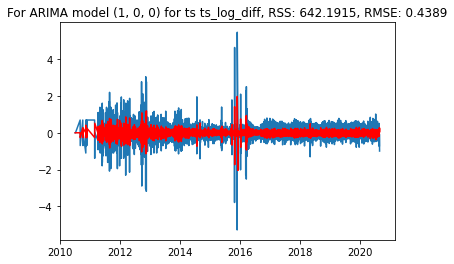

C:\Users\Chaitanya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Chaitanya\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


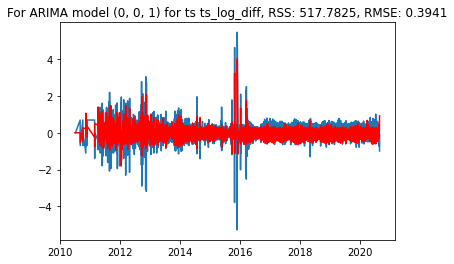

C:\Users\Chaitanya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


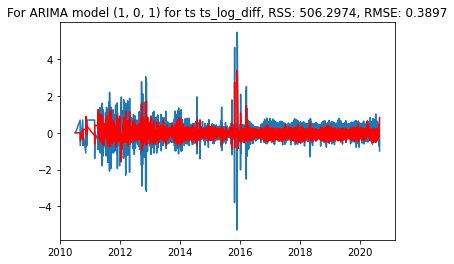

In [21]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_MA = run_arima_model(df = df_example_transform, 
                           ts = 'ts_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)